## DOCHERTY Ronan et HOUNGUEVOU Thomas
## Rapport réseaux de neurones
### Sujet: Génération de synopsis d'anime
Réseau utilisé: **Transformer**  
[Dataset](https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews/data)

In [1]:
import torch
import torch.nn as nn


class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(embed_size, embed_size)
        self.keys = nn.Linear(embed_size, embed_size)
        self.queries = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = self.values(values)  # (N, value_len, embed_size)
        keys = self.keys(keys)  # (N, key_len, embed_size)
        queries = self.queries(query)  # (N, query_len, embed_size)

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out


class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out


class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out


class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)

        return out


class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=128,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="cpu",
        max_length=100,
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out



In [2]:
import pandas as pd

# Chargement des données depuis un fichier CSV (ou tout autre format de fichier)
data = pd.read_csv('animes.csv')

# Sélection de la colonne 'synopsis'
data = data[['synopsis']]
print("Longueur des synopsis avant nettoyage: " + str(data['synopsis'].str.len().sum()))
# Affichage de la longueur initiale

# Retirer les phrases commençant par "(Source:" et se terminant par ")"
data['synopsis'] = data['synopsis'].str.replace(r'\(Source:[^\)]+\)', '', regex=True)

# Retirer les phrases du type "[Written by MAL Rewrite]"
data['synopsis'] = data['synopsis'].str.replace(r'\[Written by MAL Rewrite\]', '', regex=True)

# Retirer les phrases Click here to update this information.
data['synopsis'] = data['synopsis'].str.replace(r'Click here  to update this information.', '', regex=True)

# Retirer les phrases No synopsis has been added for this series yet.
data['synopsis'] = data['synopsis'].str.replace(r'No synopsis has been added for this series yet.', '', regex=True)

# Retirer les phrases Blu-ray/DVD.
data['synopsis'] = data['synopsis'].str.replace(r'Blu-ray/DVD', '', regex=True)

data['synopsis'] = data['synopsis'].str.replace(r'DVD', '', regex=True)

# Retirer les caractères d'autres alphabets et gérer les valeurs nulles
data['synopsis'] = data['synopsis'].apply(lambda x: '' if pd.isnull(x) else ''.join([i if (ord('A') <= ord(i) <= ord('Z')) or (ord('a') <= ord(i) <= ord('z')) or (i in ".,!?") or i in ' ' else '' for i in str(x)]))

# Remplacer plusieurs espaces consécutifs par un seul espace
data['synopsis'] = data['synopsis'].str.replace(r'\s+', ' ', regex=True)

print("Longueur des synopsis après nettoyage: " + str(data['synopsis'].str.len().sum()))
pd.set_option('display.max_colwidth', 100)
# Affichage des premières lignes pour visualiser la structure des données
print(data.head())

Longueur des synopsis avant nettoyage: 7598609.0
Longueur des synopsis après nettoyage: 7231950
                                                                                              synopsis
0  Following their participation at the InterHigh, the Karasuno High School volleyball team attempt...
1  Music accompanies the path of the human metronome, the prodigious pianist Kousei Arima. But afte...
2  The Abyssa gaping chasm stretching down into the depths of the earth, filled with mysterious cre...
3  In order for something to be obtained, something of equal value must be lost. Alchemy is bound b...
4  After helping revive the legendary vampire Kissshot Acerolaorion Heartunderblade, Koyomi Araragi...


In [3]:
from sklearn.model_selection import train_test_split

# Séparation des données en ensembles d'entraînement et de test (par exemple, 80% pour l'entraînement et 20% pour le test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Affichage de la taille des ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement :", len(train_data))
print("Taille de l'ensemble de test :", len(test_data))

Taille de l'ensemble d'entraînement : 15448
Taille de l'ensemble de test : 3863


In [4]:
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers

synopsis_list = train_data['synopsis'].astype(str).tolist()  # Assurez-vous que les données sont bien de type str

# Initialisation du tokenizer
tokenizer = Tokenizer(models.BPE())

# Configuration du trainer
trainer = trainers.BpeTrainer(vocab_size=10000, special_tokens=['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]'])

# Entraînement du tokenizer sur les synopsis nettoyés
tokenizer.train_from_iterator(synopsis_list, trainer=trainer)

# Tokenisation des synopsis d'entraînement
encoded_train_synopsis = [tokenizer.encode(synopsis).ids for synopsis in train_data['synopsis'].astype(str)]

# Tokenisation des synopsis de test
encoded_test_synopsis = [tokenizer.encode(synopsis).ids for synopsis in test_data['synopsis'].astype(str)]

# Préparation des données pour l'entraînement
# Assurez-vous que vos données sont de la bonne taille en ajoutant des paddings si nécessaire
# Utilisez les données tokenisées dans votre modèle

# Exemple de padding des données d'entraînement pour atteindre une longueur fixe
max_length = 100  # Longueur maximale souhaitée
padded_train_synopsis = [synopsis[:max_length] + [tokenizer.token_to_id('[PAD]')] * (max_length - len(synopsis[:max_length])) if len(synopsis) < max_length else synopsis[:max_length] for synopsis in encoded_train_synopsis]

# Conversion en tensors PyTorch
padded_train_tensors = torch.tensor(padded_train_synopsis)

# Faites de même pour les données de test si nécessaire
padded_test_synopsis = [synopsis[:max_length] + [tokenizer.token_to_id('[PAD]')] * (max_length - len(synopsis[:max_length])) if len(synopsis) < max_length else synopsis[:max_length] for synopsis in encoded_test_synopsis]

padded_test_tensors = torch.tensor(padded_test_synopsis)


In [5]:
# Définir les hyperparamètres d'entraînement
src_pad_idx = tokenizer.token_to_id('[PAD]')
trg_pad_idx = tokenizer.token_to_id('[PAD]')
src_vocab_size = len(tokenizer.get_vocab())
trg_vocab_size = len(tokenizer.get_vocab())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Créer une instance de votre modèle Transformer
model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(device)

# Définir les paramètres d'entraînement
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)

# Entraînement du modèle
def train_model(model, optimizer, criterion, train_data, device, epoch, Losses, batch_size=64):
    model.train()
    epoch_loss = 0
    for i in range(0, len(train_data), batch_size):
        src = train_data[i:i+batch_size, :-1].to(device)
        trg = train_data[i:i+batch_size, 1:].to(device)

        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg.reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #On conserve les loss pour chaque epoch afin de faire le graphe plus tard
    Losses.append(epoch_loss / len(train_data))
    print(f'Epoch [{epoch+1}], Loss: {epoch_loss / len(train_data)}')


In [6]:
def evaluate_model(model, criterion, test_data, device, batch_size=64):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for i in range(0, len(test_data), batch_size):
            src = test_data[i:i+batch_size].to(device)
            trg = test_data[i:i+batch_size].to(device)

            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[:, :-1, :].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            total_loss += loss.item()

    average_loss = total_loss / len(test_data)
    return average_loss

In [23]:
import torch
import torch.nn.functional as F

def nucleus_sampling(logits, p):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
    sampled_indices = sorted_indices[cumulative_probs > p]
    sampled_token = sampled_indices[0] if len(sampled_indices) > 0 else sorted_indices[0]
    return sampled_token.squeeze()

def generate_text(model, tokenizer, initial_sequence,temperature, max_length=50, p=0.7):
    model.eval()

    with torch.no_grad():
        src = torch.tensor([tokenizer.encode(initial_sequence).ids]).to(model.device)
        trg = torch.tensor([[tokenizer.token_to_id('[PAD]')]]).to(model.device)

        for _ in range(max_length):
            output = model(src, trg)
            output_logits = output[:, -1, :] / temperature
            sampled_token = nucleus_sampling(output_logits, p)
            trg = torch.cat([trg, sampled_token.unsqueeze(0).unsqueeze(0)], dim=1)

        generated_ids = trg.squeeze().tolist()
        generated_text = tokenizer.decode(generated_ids)

        return generated_text

In [8]:
epochs = 20
Losses  =[]
for epoch in range(epochs):# Entraîner le modèle
    train_model(model, optimizer, criterion, padded_train_tensors, device,epoch, Losses)
    # Sauvegarder le model
    torch.save(model, f'model_epoch_{epoch+1}.pth')

Epoch [1], Loss: 0.1251375424559409
Epoch [2], Loss: 0.08998312174131808
Epoch [3], Loss: 0.06393607679208531
Epoch [4], Loss: 0.04584844300069073
Epoch [5], Loss: 0.03302523598715408
Epoch [6], Loss: 0.023756140789980718
Epoch [7], Loss: 0.01697609945938786
Epoch [8], Loss: 0.011995895581965246
Epoch [9], Loss: 0.008365182025654214
Epoch [10], Loss: 0.0057701138149636325
Epoch [11], Loss: 0.003967896620885255
Epoch [12], Loss: 0.0027507367736314134
Epoch [13], Loss: 0.0019429490131295634
Epoch [14], Loss: 0.0014075038019916914
Epoch [15], Loss: 0.0010478744316597265
Epoch [16], Loss: 0.0008004006012359751
Epoch [17], Loss: 0.000625062972748028
Epoch [18], Loss: 0.0004972488824847231
Epoch [19], Loss: 0.00040166821306188415
Epoch [20], Loss: 0.0003286119175960075


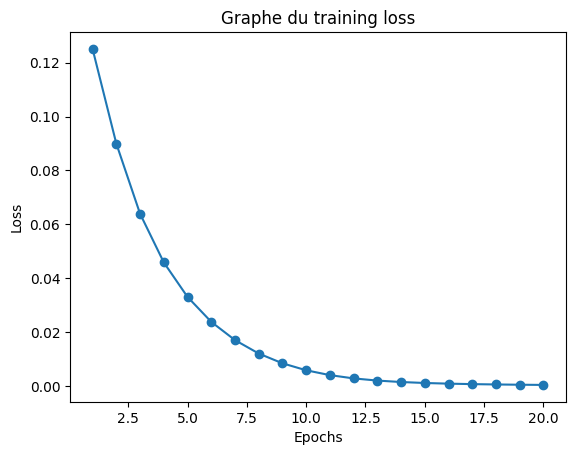

In [9]:
import matplotlib.pyplot as plt

Epochs =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# Créer le graphe
plt.plot(Epochs, Losses, marker='o', linestyle='-')

# Ajouter des labels et un titre
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Graphe du training loss')

# Afficher le graphe
plt.show()

In [24]:
initial_sequence = "In a world where"

for i in range(20):
    print("Epoch " + str(i+1))
    model = torch.load(f'model_epoch_{i+1}.pth')
    x=0.5
    while x<2:
        generated_text = generate_text(model, tokenizer, initial_sequence,x)
        # Example post-processing:
        generated_text = ' '.join(generated_text.split())  # Remove repeated spaces
        generated_text = ''.join(filter(str.isprintable, generated_text))  # Remove non-printable characters
        print(str(x) + " Generated Text:", generated_text)
        x=x+0.1
    print("")

Epoch 1
0.5 Generated Text: perform at first s. However, distr Tsubas or, ing from a me hous study Hachi Ky is, ipp Sayaka e. But decides to anc beautiful and ai effor scenes fight against the ation to ito fashion ain i, who another, ed to the humanoid is not challeng ther plan to pleasure ark uj us and . Thus partner, ed as the ste Cre akawa pl A. skir fashion comedy
0.6 Generated Text: years led by the hold compl meet ong de ifying possible k and thre sn all that leads to ionally with a s amur s that Kyou Wh best friend robot ug apprentice ed from er, a she lip Neko advert ec res set out s a evol qu unique lucky ed on a he was grant they meet terr ade apparently adult Hun sisters, development e, she
0.7 Generated Text: idols ochan woman, Akira life of a p idol machin s. But collap Shig link mor desp concer political oppon past. galaxy uy Y oto youkai a t Hon former An video scattered fo ords con classmates owned cha ts and sat of all e her isc towards insp Tur On the high ...? what d